<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

Импортируем библиотеки

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/autoruwithnamev4' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

Для парсинга кооректных ссылок воспользовался Селениум, для сбора инфы по страницам Бьютифул Супом.
Часть данных (около половины) скопировал из открытых источников (выгрузка была от ноября 2021 года), другую половину спарсил сам.
Парсил частями по 98 страниц (не получилось выгружать больше), после обработки и записи в датафреймы выгружал в эксель, потом собрал несколько файлов в один руками.
Приведу последнюю часть используемого кода, когда понял, что нужно спарсить машины с 2000 по 2010 года, т.к. их было мало в собранном до этого трейне.

In [7]:
'''
from bs4 import BeautifulSoup 
import numpy as np
import time
import copy
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from collections import OrderedDict
'''

Иногда Хром полностью блочился капчей, переходил на Мозилу.

Сначала собираем список корректных ссылок Селениумом

In [8]:
'''
spisok_ssylok = []
for i in range(2,99):
    s = Service('C:\Program Files\Google\Chrome\Application\chromedriver.exe')
    #service = Service('C:\Games\geckodriver.exe')
    #driver1 = webdriver.Firefox(service = service)
    #headers = {'Cookie': 'autoru_gdpr=1'}
    driver1 = webdriver.Chrome(service = s)
    url1 = 'https://auto.ru/moskva/cars/all/?year_from=2000&km_age_from=700&year_to=2010&catalog_filter=mark%3DVOLKSWAGEN&catalog_filter=mark%3DSKODA&catalog_filter=mark%3DBMW&catalog_filter=mark%3DAUDI&catalog_filter=mark%3DMERCEDES&page='+str(i)
    driver1.get(url1)
    elem = driver1.find_elements(By.CLASS_NAME,"ListingItemTitle__link")
    for el in range(len(elem)):
            spisok_ssylok.append(elem[el].get_attribute('href'))
    time.sleep(0.5)
'''

Переходим по каждой ссылке, добавляем инфу в список, отдельно парсим цену и имя, обрабатываем выгрузку, учитывая кириллицу. Для проверки, что не заблочены действия капчей, добавил принт количества спаршенных машин.

In [9]:
'''
test = []
for x in range(len(spisok_ssylok)):
    url = spisok_ssylok[x]
    response = requests.get(url)
    response.encoding = 'utf-8'
    page = BeautifulSoup(response.text, 'html.parser')
    try:
        data = page.find(class_='CardInfo')
        gg = data.find_all('li')  
        ustal = []
        for i in range(len(gg)):
            kk = gg[i].find_all('span')
            for x in range(len(kk)):
                mm = (kk[x].text).replace('\xa0','')
                ustal.append(mm)
        price = str(page.find(class_ = 'OfferPriceCaption__price').text).replace('\xa0','')
        name = str(page.find(class_ = 'CardHead__title').text).replace('\xa0','')
        ustal.append('price')
        ustal.append(price)
        ustal.append('name')
        ustal.append(name)
        test.append(ustal)
        time.sleep(0.2)
    except:
        pass
    print(len(test))
'''

Полученный список обрабатываем, переносим в словарь по ключам первого авто, добавляем остальные. Делаем из словаря датафрейм для удобства.

In [10]:
'''
ordered_spisok =[]
for x in range(len(test)):
    ordered = list(OrderedDict.fromkeys(test[x]))
    ordered_spisok.append(ordered)
y = ordered_spisok[0]
test_dict = {}
for i in range(0,len(y)-1):
    if i==0:
        test_dict.update({y[i]:y[i+1]})
    elif i%2 ==0:
        test_dict.update({y[i]:y[i+1]})
for key, value in test_dict.items():
    for k in range(len(ordered_spisok)):
        for i in range(len(ordered_spisok[k])):
            #for u in range(len(ordered_spisok[k][i])):
            if i%2==1:
                if key == ordered_spisok[k][i-1]:
                    test_dict[key]+=('|' + ordered_spisok[k][i])
df = pd.DataFrame.from_dict(test_dict, orient='index')
df = df[0].str.split('|', expand=True)
df = df.T
df
'''

Экспортируем в эксель

In [11]:
#df.to_excel('3094oldauto.xlsx')

In [12]:
!ls '../input'

In [13]:
train = pd.read_excel('../input/autoruwithnamev4/Auto.ru_synth2.xls') # датасет для обучения модели спаршенный в феврале 22 и взятый наполовину из данных ноября 21 года
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

Посмотрим на количество пропусков и столбцы

In [14]:
train.info()

In [15]:
test.info()

Переименуем столбцы в трейне как в тесте, оставим столбцы необходимые для построения модели.
Оставим только бренды, которые есть в тесте. Скорректируем цену для февральских данных (у спаршенных мной был Вин номер), уменьшив ее на 10% - попытка привести к уровню цен ноября 21 года.
После этого применяем коэффициенты для разных брендов (пытался учесть степень локализации брендов, т.к. у Шкоды и Фольксвагена завод в России и почти все модели производят здесь же).
В целом получилось снижение цен примерно на 30% - соответствует уровню инфляции с октября 20 года.

In [16]:
train_corr = train.rename({'год выпуска': 'productionDate', 'Пробег': 'mileage', 'Кузов': 'bodyType','Цвет':'color','Двигатель':'engineDisplacement','Мощность, л.с.':'enginePower','Тип Двигателя':'fuelType','Коробка':'vehicleTransmission' , 'Brand': 'brand'}, axis=1)
train_corr = train_corr.dropna(subset=['fuelType'])
columns = ['productionDate','mileage','color','bodyType','engineDisplacement','enginePower','fuelType','vehicleTransmission','brand','Владельцы','model_name']
#columns = ['productionDate','mileage','engineDisplacement','enginePower','vehicleTransmission','brand']
branddrop = test['brand'].unique()
train_corr['brand'] = train_corr['brand'].str.upper()
train_corr['brand_corr'] = train_corr['brand'].apply(lambda x: x if x in branddrop else 'delete')
train_corr = train_corr.loc[train_corr['brand_corr'] != 'delete']
train_corr['price'] = train_corr.apply(lambda x:x['price']*0.9 if x['VIN'] != '' else x, axis =1)
train_corr['price'] = train_corr['price'].astype(int)
train_corr['price'] = train_corr.apply(lambda x: x['price']*0.7 if x['brand'] == 'BMW' else( x['price']*0.82 if x['brand']=='Skoda' else ( x['price']*0.73 if x['brand']=='Mercedes' else ( x['price']*0.71 if x['brand']=='Audi' else ( x['price']*0.8 if x['brand']=='Volkswagen' else x['price']*0.76)))),axis=1)
#train['price'] = train['price'].apply(lambda x: x*0.56)
train_corr['price'] = train_corr['price'].astype(int)
train_corr['model_name'] = train_corr['model_name'].astype(str)

Сделаем сторонний датасет чекнуть влияние числовых признаков на цену

In [17]:
df_check = train.rename({'год выпуска': 'productionDate', 'Пробег': 'mileage', 'Кузов': 'bodyType','Цвет':'color','Двигатель':'engineDisplacement','Мощность, л.с.':'enginePower','Тип Двигателя':'fuelType','Коробка':'vehicleTransmission' , 'Brand': 'brand'}, axis=1)
df_check = train_corr.dropna(subset=['fuelType'])
columns_test = ['productionDate','mileage','color','bodyType','engineDisplacement','enginePower','fuelType','vehicleTransmission','brand','Владельцы','model_name','price']
df_check['brand'] = df_check['brand'].str.upper()
df_check['brand_corr'] = df_check['brand'].apply(lambda x: x if x in branddrop else 'delete')
df_check = df_check.loc[df_check['brand_corr'] != 'delete']
df_check['price'] = df_check.apply(lambda x:x['price']*0.85 if x['VIN'] != '' else x, axis =1)
df_check['price'] = df_check['price'].astype(int)
df_check['price'] = df_check.apply(lambda x: x['price']*0.5 if x['brand'] == 'BMW' else( x['price']*0.55 if x['brand']=='Skoda' else ( x['price']*0.5 if x['brand']=='Mercedes' else ( x['price']*0.5 if x['brand']=='Audi' else ( x['price']*0.54 if x['brand']=='Volkswagen' else x['price']*0.52)))),axis=1)
#train['price'] = train['price'].apply(lambda x: x*0.56)
#train_corr['price'] = train_corr['price'].astype(int)
df_check['model_name'] = df_check['model_name'].astype(str)


label_encoder = LabelEncoder()

bin_cols = ['color', 'vehicleTransmission', 'brand', 'fuelType', 'Владельцы']

for column in bin_cols:
    df_check[column] = label_encoder.fit_transform(df_check[column])

df_check['f1'] = df_check['productionDate']*df_check['mileage']
df_check['engineDisplacement'] = df_check['engineDisplacement'].apply(lambda x: x.replace(' LTR', ''))
df_check['enginePower'] =df_check['enginePower'].apply(lambda x: x.replace(' N12', ''))
df_check['engineDisplacement'] = pd.to_numeric(df_check['engineDisplacement'],downcast='integer')
df_check['enginePower'] = pd.to_numeric(df_check['enginePower'])
df_check['engineDisplacement'] = df_check['engineDisplacement'].fillna(df_check['engineDisplacement'].median())
df_check['f2'] = df_check['enginePower'] * df_check['engineDisplacement']
df_check['f3'] = df_check['f1']/df_check['f2']
df_check['f4'] = df_check['enginePower']*df_check['fuelType']

In [18]:
num_cols_check = ['productionDate', 'mileage','price','engineDisplacement','enginePower', 'f1','f2','f3','f4','color','vehicleTransmission','brand', 'fuelType', 'Владельцы']
num_cols_1= ['productionDate', 'mileage','engineDisplacement','enginePower', 'f1','f2','f3','f4','color','vehicleTransmission','brand', 'fuelType', 'Владельцы']

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_check[num_cols_check].corr().abs(), vmin=0, vmax=1, linewidths=.3)

Видим, что у цены самая большая корреляция с мощностью мотора и с новыми фичами, созданными на его основе

In [20]:
imp_num = pd.Series(f_classif(df_check[num_cols_1], df_check['price'])[0], index = num_cols_1)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Еще раз убедились в важности новых двух фич и мощности мотора

In [21]:
IQR = train_corr['productionDate'].quantile(0.75) - train_corr['productionDate'].quantile(0.25)
perc25 = train_corr['productionDate'].quantile(0.25)
perc75 = train_corr['productionDate'].quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

In [22]:
IQR = train_corr['mileage'].quantile(0.75) - train_corr['mileage'].quantile(0.25)
perc25 = train_corr['mileage'].quantile(0.25)
perc75 = train_corr['mileage'].quantile(0.75)

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

Несмотря на выбросы по годам и пробегу, решил не удалять их, т.к. на точность модели это не оказало воздействия

Делаем трейн и тест

In [23]:
df_train = train_corr[columns]
df_test = test[columns]
y = train_corr['price']

In [24]:
df_train.info()

Пропусков нет, можем приступать к созданию тех фич, о которых писал выше, к кодированию категориальных признаков и подготовке данных.

## Data Preprocessing

In [25]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Обработка числовых данных

In [26]:
data['f1'] = data['productionDate']*data['mileage']
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: x.replace(' LTR', ''))
data['enginePower'] =data['enginePower'].apply(lambda x: x.replace(' N12', ''))
data['engineDisplacement'] = pd.to_numeric(data['engineDisplacement'],downcast='integer')
data['enginePower'] = pd.to_numeric(data['enginePower'])
data['engineDisplacement'] = data['engineDisplacement'].fillna(data['engineDisplacement'].median())
data['f4'] = data['enginePower']*data['productionDate']

Логарифмируем, чтобы распределение больше походило на нормальное

In [27]:
data['productionDate'] = np.log(data['productionDate'])
data['mileage'] = np.log(data['mileage'])
data['engineDisplacement'] = np.log(data['engineDisplacement'])
data['enginePower'] = np.log(data['enginePower'])
data['f1'] = np.log(data['f1'])
data['f4'] = np.log(data['f4'])

Категориальные признаки кодируем Onehotencoder

In [28]:
data_cata = data[['bodyType','vehicleTransmission','brand']]

one_hot = OneHotEncoder()
data_fixed = one_hot.fit_transform(data_cata)
data_df = data.join(pd.DataFrame(data_fixed.toarray()))
data_df = data_df.drop(['bodyType','model_name','color', 'vehicleTransmission', 'brand', 'fuelType', 'Владельцы','engineDisplacement'],axis = 1)
data_df

#категори енкодер показал худшие результаты на модели
#import category_encoders as ce
#encoder = ce.BackwardDifferenceEncoder(cols=['vehicleTransmission','brand','bodyType'])
#encoder.fit(data, verbose=1)
#data_to_test = encoder.fit_transform(data, verbose=1)

Оставил всего 3 категориальных признака, т.к. при добавлении цвета, количества владельцев или имени машины модель переобучалась и я долго мучился с ЛБ.
Когда оставил 3 признака сразу улучшил результат в 2 раза.

In [29]:
num_cols_check = ['productionDate','mileage','enginePower','f1','f4']
for i in num_cols_check:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Стандартизировать данные не стал, ухудшалось качество

In [30]:
X = data_df.query('sample == 1').drop(['sample'], axis=1)
X_sub = data_df.query('sample == 0').drop(['sample'], axis=1)

# ## **Model**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Бейзлайн и Кэт бустинг стер

Пробую регрессоры, т.к. задача регресии
Пытался запустить Lazy predict regressor, но умирал кэггл от перегрузки, нашел такую картинку с большим количеством регрессоров, попробовал некоторые из них
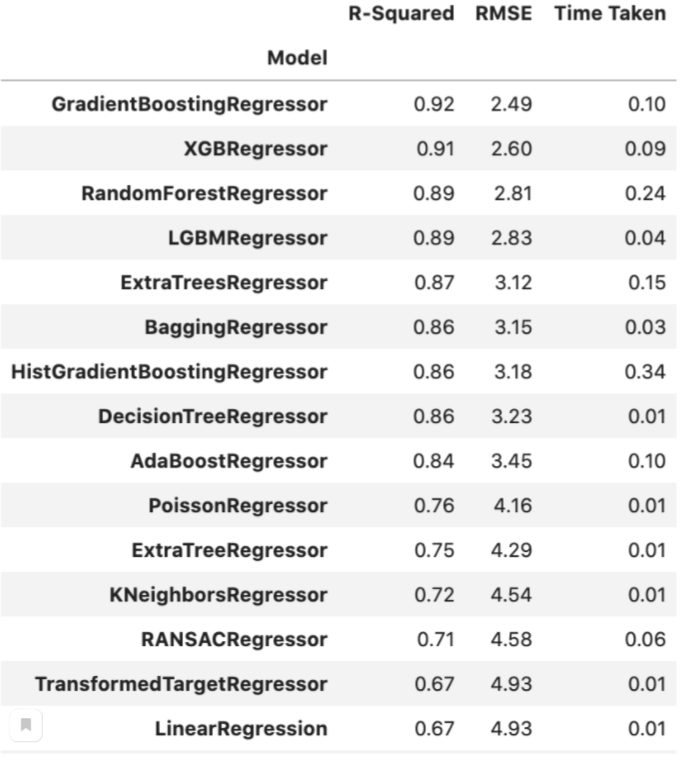

In [33]:
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=50), n_estimators=300, random_state=RANDOM_SEED)
regr_2.fit(X, y)
predict_regr2 = regr_2.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_regr2))*100:0.2f}%")

In [34]:
reg = SGDRegressor(max_iter=1000,random_state=RANDOM_SEED)
reg.fit(X_train, y_train)
predict_SGD = reg.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_SGD))*100:0.2f}%")

In [35]:
xgbr = xgb.XGBRegressor(verbosity=0,learning_rate=0.6,max_depth = 10, n_estimators = 200,random_state=RANDOM_SEED) 
xgbr.fit(X_train, y_train)
predict_xgbr = xgbr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_xgbr))*100:0.2f}%")

In [36]:
est = GradientBoostingRegressor(n_estimators=400, learning_rate=0.3,max_depth=10, random_state=RANDOM_SEED, loss='ls').fit(X_train, y_train)
predict_est = est.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_est))*100:0.2f}%")

Делаю стекинг 3 регрессоров

Модели выбирал опытным путем, эти три показали лучшие результаты на ЛБ

In [37]:
estimators = [('lr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.3,max_depth=10, random_state=42, loss='ls')),('svr',RandomForestRegressor(n_estimators=100,max_depth = 10,random_state=42))]
reg = StackingRegressor(estimators=estimators,final_estimator=xgb.XGBRegressor(verbosity=0,learning_rate=0.6,max_depth = 10, n_estimators = 200,random_state =42))
reg.fit(X_train,y_train)
predict = reg.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

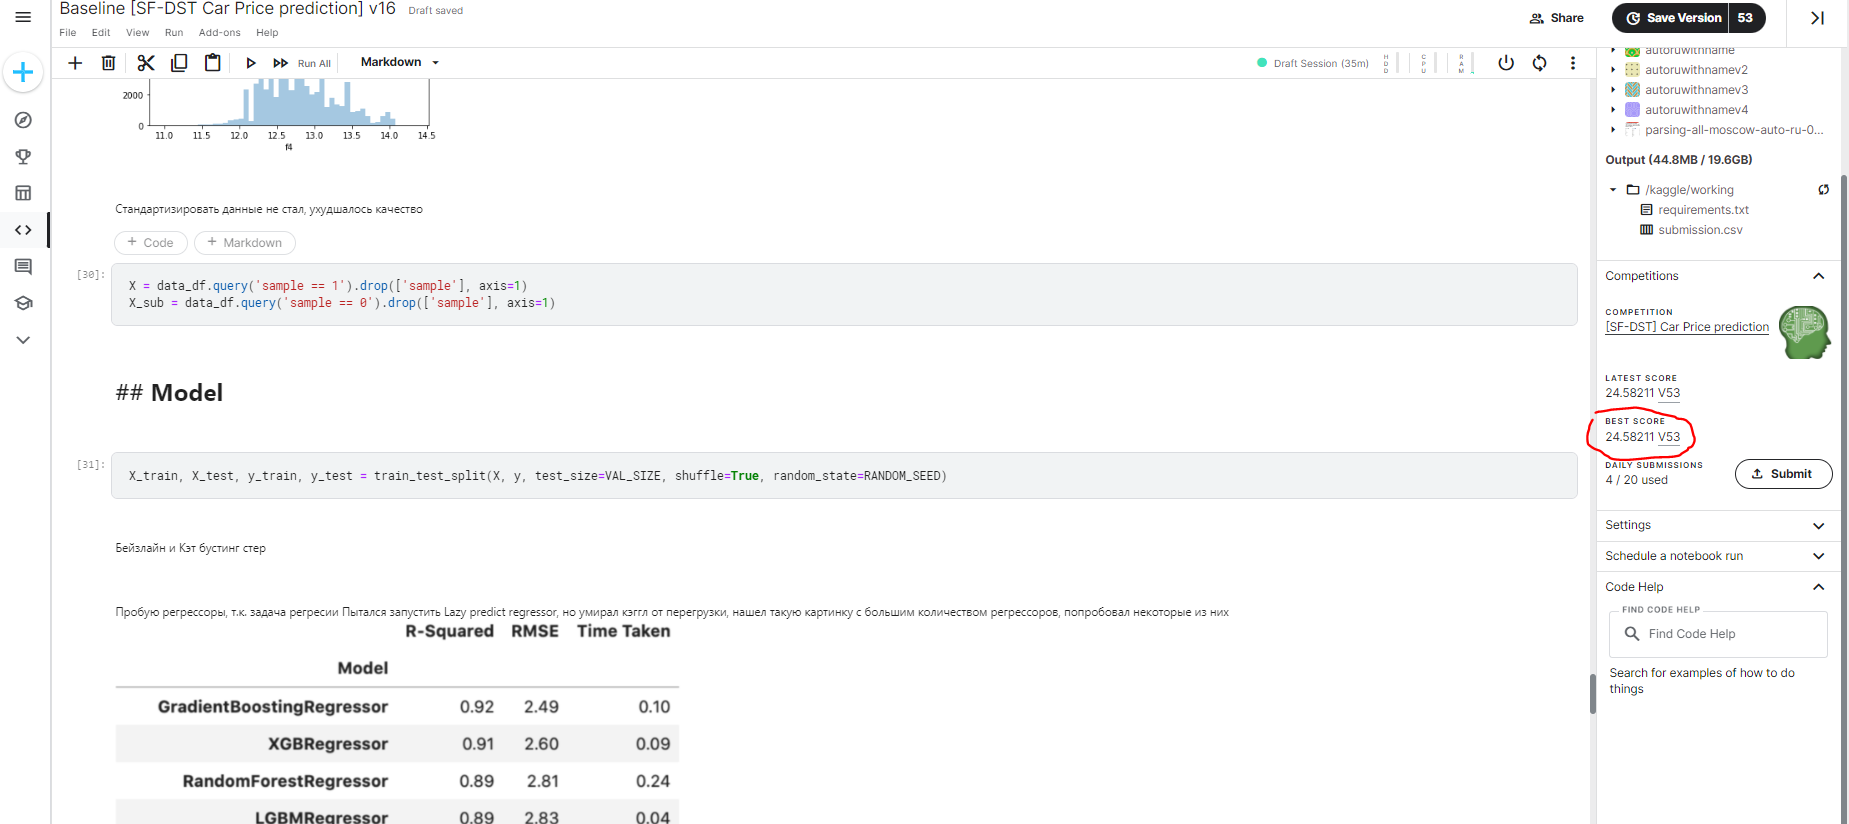

стекинг улучшил результат на лб на 0,2%

In [38]:
predict_test = reg.predict(X_test)
predict_submission = reg.predict(X_sub)

In [39]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Как видим точность возросла до 15%, а что будет на ЛБ?

# Submission

In [40]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

In [41]:
gg = pd.read_csv('submission.csv')
gg

In [42]:
!kaggle competitions submit -c sf-dst-car-price-prediction -f submission.csv -m "Message"

В итоге получили **MAPE 24,6%** на ЛБ!

Можно улучшить модель спарсив около 15 тысяч машин с 1999 по 2010 года (сейчас их мало в трейне, а в тесте много), поподбирать дальше коэффициенты цены, параметры моделей
